In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans

In [3]:
TEXT_COLOR = '#313131'
LINE_COLORS = ['#00A082', '#F2CC38', '#9B59B6', '#3498DB', '#F39C12']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 120,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif', # 'Open Sans',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

# 1. Load the data

In [4]:
data = pd.read_csv('../data/house-prices-dataset/train.csv')

In [5]:
# Selecting top-predictor columns IMO
cols = [
    'OverallQual', 
    'GrLivArea',
    'ExterQual',
    'GarageCars',
    'YearBuilt',
    'YearRemodAdd',
    'TotRmsAbvGrd',
    'Foundation',
    'Fireplaces',
    'FireplaceQu',
    'HeatingQC',
    'SalePrice'
]

In [6]:
data = data[cols]

In [7]:
def col_to_dummies(df, col):
    return pd.concat(
        [data, pd.get_dummies(data[col], prefix=col, drop_first=True)], 
        axis=1
    ).drop(col, axis=1)

In [8]:
data['FireplaceQu'] = data['FireplaceQu'].map({
    np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
})

In [9]:
data['HeatingQC'] = data['HeatingQC'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [10]:
data['ExterQual'] = data['ExterQual'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [11]:
data = col_to_dummies(data, 'Foundation')

In [12]:
# Remove the outlier
data = data.copy().drop(index=1298, axis=0)

# 2. Apply k-means

### 2.1. Apply to raw data

In [13]:
km = KMeans(n_clusters=3, random_state=42)

In [14]:
km.fit(data.drop("SalePrice", axis=1))

KMeans(n_clusters=3, random_state=42)

In [15]:
data['cluster'] = km.labels_

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

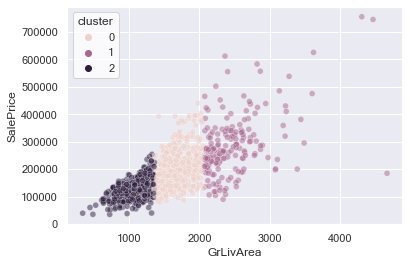

In [16]:
sns.scatterplot(data=data, x='GrLivArea', y='SalePrice', hue='cluster', alpha=0.5)

Seems like GrLivArea was the most decisive factor to assign clusters because it is of large numbers.

### 2.2. Apply to scaled data

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

In [19]:
scaled = pd.DataFrame(scaler.fit_transform(data.drop("SalePrice", axis=1)), columns=data.columns.drop("SalePrice"))

In [20]:
km = KMeans(n_clusters=3, random_state=42)

In [21]:
km.fit(scaled)

KMeans(n_clusters=3, random_state=42)

In [22]:
scaled['cluster'] = km.labels_

In [23]:
scaled["SalePrice"] = data["SalePrice"].copy()

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

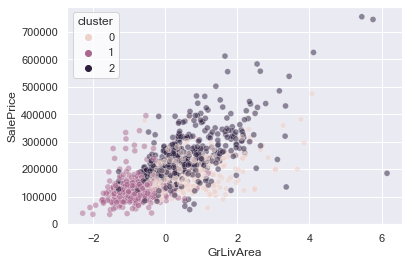

In [24]:
sns.scatterplot(data=scaled, x='GrLivArea', y='SalePrice', hue='cluster', alpha=0.5)

### 2.3. Use k-means clusters as feature in a model

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = data.drop(["SalePrice", "cluster"], axis=1).copy()

In [27]:
y = data['SalePrice'].copy()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=101)

In [29]:
# Scale X
scaler = StandardScaler()
X_train[:] = scaler.fit_transform(X_train[:])
X_test[:] = scaler.transform(X_test[:])

Apply to training set and then predict on validation set

In [30]:
km = KMeans(n_clusters=3, random_state=42)

In [31]:
X_train["cluster"] = km.fit(X_train).labels_

In [32]:
X_test["cluster"] = km.predict(X_test)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [34]:
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'''MAE:\t{mae}\nRMSE:\t{rmse}''')
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.plot(*2*[np.arange(0,500000)], color='r', ls='--')
    plt.xlabel('y true')
    plt.ylabel('y pred')
    plt.ylim(0, 500000)
    plt.xlim(0, 500000)
    plt.show()

#### 2.3.1 No clustering

In [35]:
from statsmodels.formula.api import ols

In [36]:
training_data = pd.concat((X_train, y_train), axis=1)

In [37]:
model = ols(
    formula=f"np.log(SalePrice) ~ {' + '.join(training_data.drop(['SalePrice', 'cluster'], axis=1).columns)}",
    data=training_data.drop("cluster", axis=1)
).fit()

In [38]:
y_pred = model.predict(X_test.drop("cluster", axis=1))

In [39]:
y_pred = np.exp(y_pred)

MAE:	20936.539184083547
RMSE:	30731.26464516074


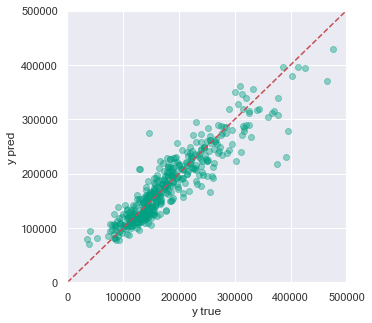

In [40]:
evaluate(y_test, y_pred)

#### 2.3.1 With clustering

In [41]:
model = ols(
    formula=f"np.log(SalePrice) ~ {' + '.join(training_data.drop(['cluster', 'SalePrice'], axis=1).columns)} + C(cluster)",
    data=training_data
).fit()

In [42]:
y_pred = model.predict(X_test)

In [43]:
y_pred = np.exp(y_pred)

MAE:	20693.807433928792
RMSE:	30453.06123606185


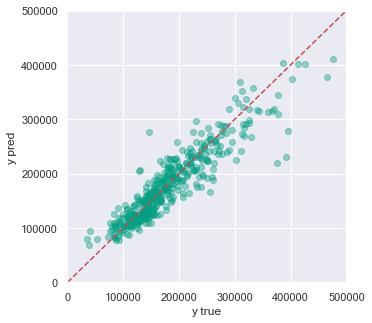

In [44]:
evaluate(y_test, y_pred)

---

# 3. Conclusion
1. Always scale the data when applying K-means.
2. Using k-means as feature does not improve performance, at least for this specific data set and at least with linear regression.

---